

# Code References:
1.   Unsupervised_hello_world.Ipynb at master · tensorflow/similarity. [link text](https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb)
2.   B. Ko, CBAM-keras: CBAM implementation on keras. [link text]( https://github.com/kobiso/CBAM-keras)
3.   Keras Team, “Grad-CAM class activation visualization,” Keras.io. [Online]. Available: [link text](https://keras.io/examples/vision/grad_cam/)
4.   S. Loukas, “Multi-class Classification: Extracting performance metrics from the confusion matrix,” Towards Data Science, 19-Jun-2020. [Online]. Available: https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872. [Accessed: 30-Apr-2022].






In [ ]:
!pip install tensorflow-addons
!pip install tensorflow_similarity

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/')
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d26bc67b-7403-a577-d5f3-9c175692cf01)


TensorFlow: 2.8.0
TensorFlow Similarity 0.15.8


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteUFEH2X/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteUFEH2X/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
       Examples            Labels
-----  ------------------  --------
train  (45000, 32, 32, 3)  (45000,)
val    (1000, 32, 32, 3)   (1000,)
query  (2000, 32, 32, 3)   (2000,)
index  (2000, 32, 32, 3)   (2000,)
test   (10000, 32, 32, 3)  (10000,)


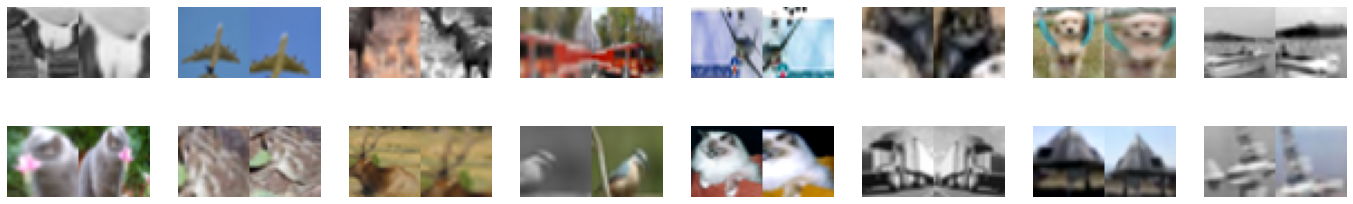

This is backbone
Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182906  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,906
Trainable params: 11,173,178
Non-trainable params: 9,728
_________________________________________________________________
End of backbone Summary
Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]  

In [ ]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# install TF addons if needed
try:
	import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
	# !pip install tensorflow-addons
	import tensorflow_addons as tfa

# install TF similarity if needed
try:
	import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
	# !pip install tensorflow_similarity
	import tensorflow_similarity as tfsim

import tensorflow as tf
import tensorflow_datasets as tfds
import cbam_unit as cb
import resnet18_with_attention as rscb
#%%

tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
	DATA_PATH.mkdir(parents=True)


((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
	"cifar10",
	split=["train", "test"],
	batch_size=-1,
	shuffle_files=True,
	as_supervised=True,
	with_info=True,
)

# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
	idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
	idxs = tf.reshape(idxs, (-1,))
	query_idxs.extend(idxs[:200])     # 200 query examples per class
	index_idxs.extend(idxs[200:400])  # 200 index examples per class
	val_idxs.extend(idxs[400:500])    # 100 validation examples per class
	train_idxs.extend(idxs[500:])     # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

def create_split(idxs: list) -> tuple:
	x, y = [], []
	for idx in idxs:
		x.append(x_raw_train[int(idx)])
		y.append(y_raw_train[int(idx)])
	return tf.convert_to_tensor(np.array(x)), tf.convert_to_tensor(np.array(y))

x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

print(
	tabulate(
		[
			["train", x_train.shape, y_train.shape],
			["val", x_val.shape, y_val.shape],
			["query", x_query.shape, y_query.shape],
			["index", x_index.shape, y_index.shape],
			["test", x_test.shape, y_test.shape],
		],
		headers=["Examples", "Labels"],
	)
)

ALGORITHM = "simclr"

"""### Training Parameter Setup"""

CIFAR_IMG_SIZE = 32


if ALGORITHM == "simclr":
	BATCH_SIZE = 512
	PRE_TRAIN_EPOCHS = 400
	PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
	VAL_STEPS_PER_EPOCH = 20
	WEIGHT_DECAY = 5e-4
	INIT_LR = 1e-3  # Initial LR for the learning rate schedule, see section B.1 in the paper.
	TEMPERATURE = 0.5 # Tuned for CIFAR10, see section B.9 in the paper.
	DIM = 2048  # The layer size for the projector and predictor models.

@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
	# random resize and crop. Increase the size before we crop.
	img = tfsim.augmenters.simclr.crop_and_resize(
		img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=area_range
	)
	img /= 255.0
	# random color jitter
	def _jitter_transform(x):
		return tfsim.augmenters.simclr.color_jitter_rand(
			x,
			np.random.uniform(0.0, 0.4),
			np.random.uniform(0.0, 0.4),
			np.random.uniform(0.0, 0.4),
			np.random.uniform(0.0, 0.1),
			"simclrv2",
		)

	img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)

	# # random grayscale
	def _grascayle_transform(x):
		return tfsim.augmenters.simclr.to_grayscale(x)

	img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)

	# optional random gaussian blur
	if blur:
		img = tfsim.augmenters.simclr.random_blur(img, p=0.5)

	# random horizontal flip
	img = tf.image.random_flip_left_right(img)
	img = tf.clip_by_value(img, 0.0, 1.0)

	return img


@tf.function()
def process(img):
	# The augmenters return scaled values between [0,1]
	view1 = simsiam_augmenter(img, blur=False)
	view2 = simsiam_augmenter(img, blur=False)
	# The ResNet model scales internally and expects the inputs to be between [0, 255]
	return (view1 * 255.0, view2 * 255.0)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


tfsim.visualization.visualize_views(
	views=next(train_ds.as_numpy_iterator()),
	num_imgs=16,
	views_per_col=8,
	max_pixel_value=255.0,
)

def get_backbone(
	img_size, activation="relu", preproc_mode="torch"
):
	input_shape = (img_size, img_size, 3)
	backbone = rscb.ResNet18Sim(
		input_shape,
		include_top=False,  # Take the pooling layer as the output.
		pooling="avg",      # Can change to use `gem` -> GeneralizedMeanPooling2D
		# gem_p=3.0,        # Increase the contrast between activations in the feature map.
		preproc_mode="torch",
	)
	# backbone2 = tfsim.architectures.ResNet18Sim(
	# 	input_shape,
	# 	include_top=False,  # Take the pooling layer as the output.
	# 	pooling="avg",      # Can change to use `gem` -> GeneralizedMeanPooling2D
	# 	# gem_p=3.0,        # Increase the contrast between activations in the feature map.
	# 	preproc_mode="torch",
	# )
	return backbone


backbone = get_backbone(CIFAR_IMG_SIZE)
print("This is backbone")
backbone.summary()
print("End of backbone Summary")

def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
	inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
	x = inputs
	
	for i in range(num_layers - 1):
		x = tf.keras.layers.Dense(
			dim,
			use_bias=False,
			kernel_initializer=tf.keras.initializers.LecunUniform(),
			name=f"projector_layer_{i}",
		)(x)
		x = tf.keras.layers.BatchNormalization(
			epsilon=1.001e-5, name=f"batch_normalization_{i}"
		)(x)
		x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
			x
		)
	x = tf.keras.layers.Dense(
		dim,
		use_bias=False,
		kernel_initializer=tf.keras.initializers.LecunUniform(),
		name="projector_output",
	)(x)
	x = tf.keras.layers.BatchNormalization(
		epsilon=1.001e-5,
		center=False,  # Page:5, Paragraph:2 of SimSiam paper
		scale=False,  # Page:5, Paragraph:2 of SimSiam paper
		name=f"batch_normalization_ouput",
	)(x)
	# Metric Logging layer. Monitors the std of the layer activations. 
	# Degnerate solutions colapse to 0 while valid solutions will move 
	# towards something like 0.0220. The actual number will depend on the layer size.
	o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
	projector = tf.keras.Model(inputs, o, name="projector")
	return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

def get_predictor(input_dim, hidden_dim=512, activation="relu"):
	inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
	x = inputs

	x = tf.keras.layers.Dense(
		hidden_dim,
		use_bias=False,
		kernel_initializer=tf.keras.initializers.LecunUniform(),
		name="predictor_layer_0",
	)(x)
	x = tf.keras.layers.BatchNormalization(
		epsilon=1.001e-5, name="batch_normalization_0"
	)(x)
	x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

	x = tf.keras.layers.Dense(
		input_dim,
		kernel_initializer=tf.keras.initializers.LecunUniform(),
		name="predictor_output",
	)(x)
	# Metric Logging layer. Monitors the std of the layer activations. 
	# Degnerate solutions colapse to 0 while valid solutions will move 
	# towards something like 0.0220. The actual number will depend on the layer size.
	o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
	predictor = tf.keras.Model(inputs, o, name="predictor")
	return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

if ALGORITHM == "simclr":
	loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)

	contrastive_model = tfsim.models.ContrastiveModel(
		backbone=backbone,
		projector=projector,
		algorithm=ALGORITHM,
	)
	optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
	raise ValueError(f"{ALGORITHM} is not supported.")





TensorBoard logging enable in tfsim_contrastive_model/models/logs/simclr_1650990451.289884/index
Epoch 1/400
87/87 [==============================] - 98s 679ms/step - loss: 6.0879 - proj_std: 0.0219 - val_loss: 6.2808 - val_proj_std: 0.0172 - binary_accuracy: 0.2430
Epoch 2/400
87/87 [==============================] - 55s 632ms/step - loss: 5.8065 - proj_std: 0.0221 - val_loss: 5.9043 - val_proj_std: 0.0212 - binary_accuracy: 0.2600
Epoch 3/400
87/87 [==============================] - 56s 640ms/step - loss: 5.7221 - proj_std: 0.0221 - val_loss: 5.7822 - val_proj_std: 0.0215 - binary_accuracy: 0.3055
Epoch 4/400
87/87 [==============================] - 62s 718ms/step - loss: 5.6707 - proj_std: 0.0221 - val_loss: 5.7428 - val_proj_std: 0.0215 - binary_accuracy: 0.3165
Epoch 5/400
87/87 [==============================] - 56s 647ms/step - loss: 5.6249 - proj_std: 0.0221 - val_loss: 5.7623 - val_proj_std: 0.0211 - binary_accuracy: 0.3275
Epoch 6/400
87/87 [==============================] - 

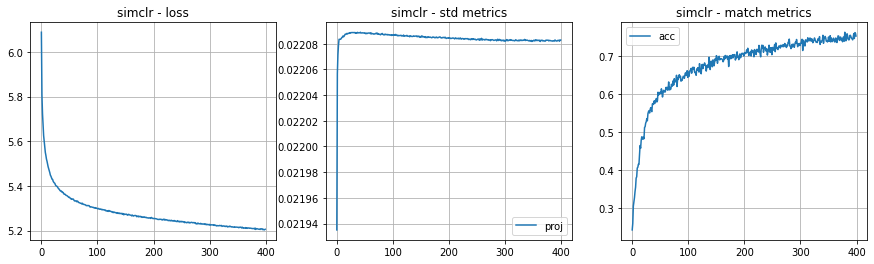

In [ ]:
contrastive_model.compile(
	optimizer=optimizer,
	loss=loss,
)

log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"


evb = tfsim.callbacks.EvalCallback(
	tf.cast(x_query, tf.float32),
	y_query,
	tf.cast(x_index, tf.float32),
	y_index,
	metrics=["binary_accuracy"],
	k=1,
	tb_logdir=log_dir,
)
tbc = tf.keras.callbacks.TensorBoard(
	log_dir=log_dir,
	histogram_freq=1,
	update_freq=100,
)
mcp = tf.keras.callbacks.ModelCheckpoint(
	filepath=chkpt_dir,
	monitor="loss",
	mode="min",
	save_best_only=True,
	save_weights_only=True,
)

history = contrastive_model.fit(
	train_ds,
	epochs=PRE_TRAIN_EPOCHS,
	steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
	validation_data=val_ds,
	validation_steps=VAL_STEPS_PER_EPOCH,
	callbacks=[evb, tbc, mcp],
)
#%%

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1,3,2)
plt.plot(history.history["proj_std"], label="proj")
if "pred_std" in history.history:
	plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - match metrics")
plt.legend()

plt.show()


In [ ]:
contrastive_model.save('/content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model')

[Saving backbone model]
|-path:/content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model/backbone


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model/backbone/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model/backbone/assets


Index not saved as save_index=False
[Saving projector model]
|-path:/content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model/projector


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model/projector/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/simclrCBAM/contrastive/final_model/projector/assets
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Text(0.5, 1.0, 'SimCLR Loss Function for the Contrastive Batches')

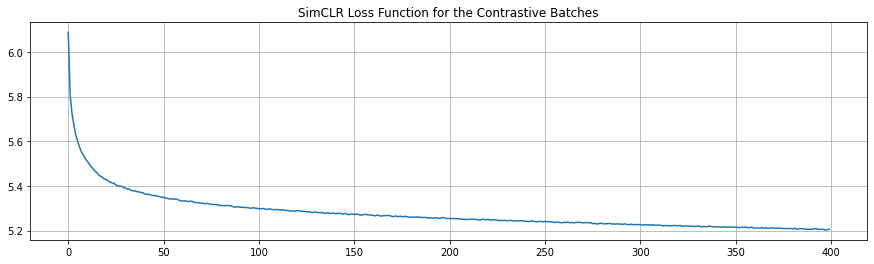

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(history.history["loss"])
plt.grid()
plt.title("SimCLR Loss Function for the Contrastive Batches")